# MILESTONE 2

IRFAN FAHMUDDIN FTDS-011

**DATASET**

cartoon vs anime

**objectives**

Classify images as an Anime or a Cartoon

## IMPORT LIBRARY

In [16]:
import pathlib
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, BatchNormalization, Reshape


## DATA LOADING

In [17]:
os.listdir('Training Data')

['Anime', 'Cartoon']

In [18]:
main_path= 'Training Data'
anime_path= os.path.join(main_path, 'Anime')
kartun_path = os.path.join(main_path, 'Cartoon')

In [19]:
data_anime= glob.glob(anime_path + '\*\*.png')
data_kartun= glob.glob(kartun_path + '\*\*.png')

In [20]:
# membuat dataframe

def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image, image.split("\\")[-3]))

  return pd.DataFrame(data, columns= ['images', 'label'])

data_df= create_dataframe(data_anime + data_kartun)
data_df= data_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [21]:
print(data_df.shape)
data_df

(6772, 2)


,images,label
0,Training Data\Anime\Get Backers\115.png,Anime
1,Training Data\Anime\Naruto Shippuden\54.png,Anime
2,Training Data\Cartoon\YogiBear\130.png,Cartoon
3,Training Data\Anime\New folder\10.png,Anime
4,Training Data\Cartoon\spongebob squarepants\11...,Cartoon
...,...,...
6767,Training Data\Anime\Death Note\38.png,Anime
6768,Training Data\Cartoon\phineas and ferb\115.png,Cartoon
6769,Training Data\Cartoon\Beat Bugs\117.png,Cartoon
6770,Training Data\Anime\Attack on Titan\13.png,Anime


## EDA

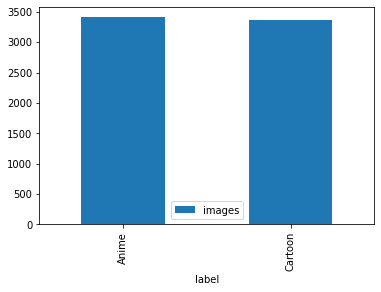

In [22]:
## jumlah data setiap label
EDA_1 = data_df.groupby('label').count().plot(kind='bar')


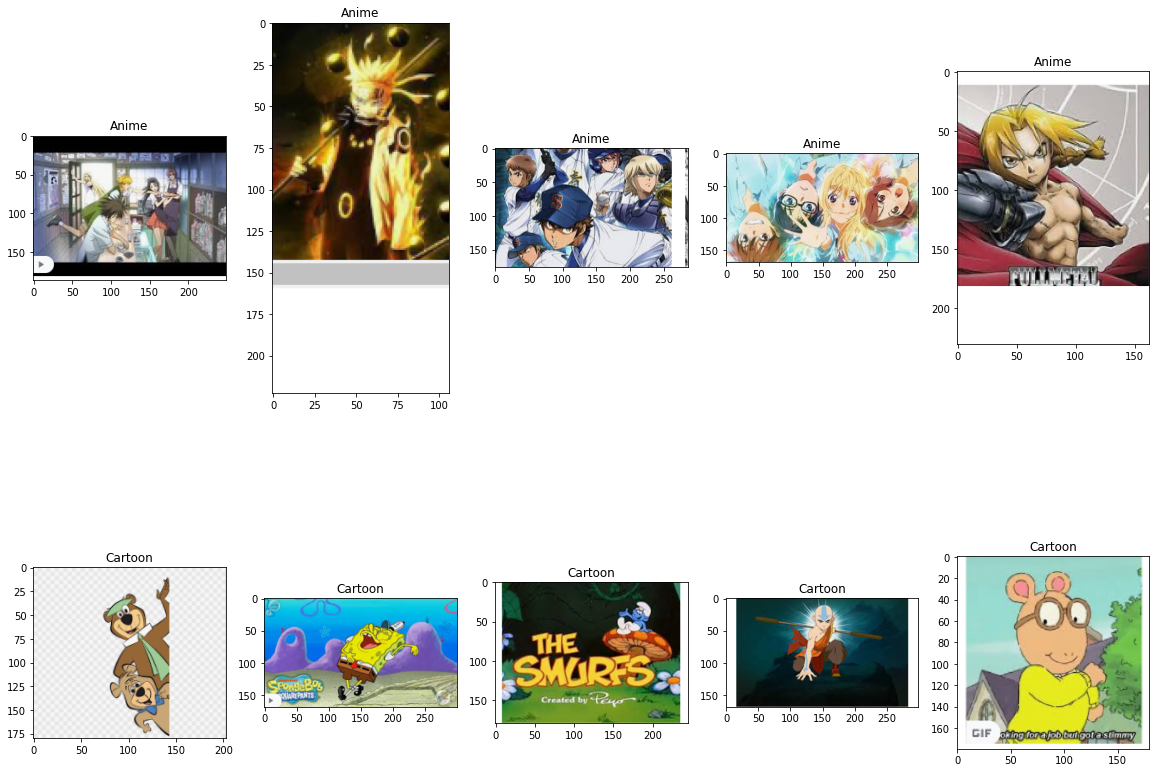

In [23]:
# visualisasi data gambar
anime_S= (data_df[data_df['label']=='Anime']['images'].iloc[:5]).tolist()
kartun_S= (data_df[data_df['label']=='Cartoon']['images'].iloc[:5]).tolist()

def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('\\')[-3])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

visualize_samples(anime_S + kartun_S)

In [24]:
h_size = []
v_size = []

In [65]:
size_data = pd.DataFrame({'hor_size': h_size, 'ver_size': v_size}) # definisi size dari data
h_size = []
v_size = []
# mendefinisikan ukuran gambar dengaan looping


for file in data_anime:
    img = cv2.imread(file)
   
    h_size.append(img.shape[0])
    v_size.append(img.shape[1])


for file in data_kartun:
    img = cv2.imread(file)
   
    h_size.append(img.shape[0])
    v_size.append(img.shape[1])

In [66]:
size_data

,hor_size,ver_size
0,170,299
1,180,174
2,207,139
3,180,240
4,200,138
...,...,...
6767,191,145
6768,180,240
6769,186,146
6770,181,241


<AxesSubplot:xlabel='ver_size', ylabel='Count'>

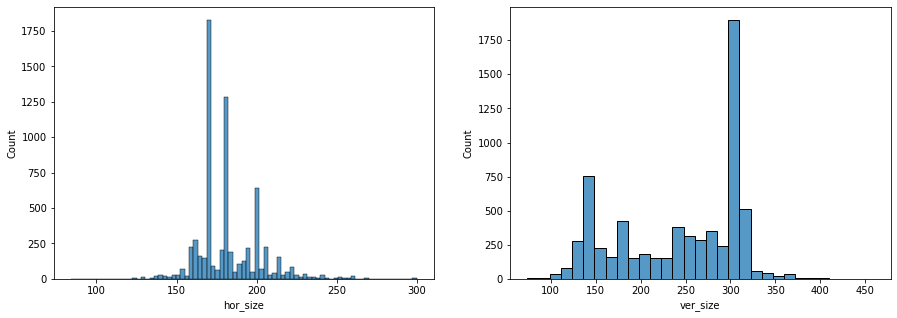

In [67]:
# plot ukuran dari gaambar anime dan kartun
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=size_data['hor_size'], ax=ax[0])
sns.histplot(data=size_data['ver_size'], ax=ax[1])

Berdasarkan data grafik diatas kita dapat mengetahui distribusi dari ukuran gambar pada dataset ini. Dapat dilihat bahwa ukuran gambar secara horizontal yang paling banyak adalah gambar dengan ukuran sekitar 170 px sedangkan untuk ukuran vertikal terbanyak sekitar 310-350 px.

<AxesSubplot:xlabel='hor_size', ylabel='ver_size'>

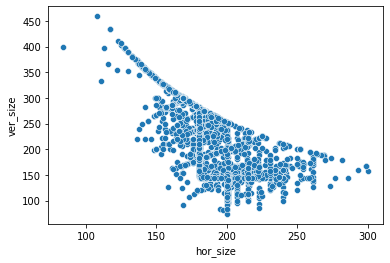

In [68]:
sns.scatterplot(x = 'hor_size', y = 'ver_size', data=size_data)

Berikut ini adalah scatter plot dari data gambar. Kita dapat lihat bahwa banyak gambar yang memiliki ukuran (150-200)px x (150-250)px. Ha menarik yang dapat dilihat ialah terdapat titik data yang tegagak lurus terhadap sumbu x yang menandakan bahwa ada beberapa data yg sama secaraaa ukuran horizontalnya namun bervariasi ukuran secara vertikal. Terlihat ada gambar dengan ukuran 200x100 , 200x110 , 200x120, dst.

In [69]:
size_data.describe()

,hor_size,ver_size
count,6772.000000,6772.000000
mean,181.479179,242.633934
std,19.616716,67.302384
min,84.000000,74.000000
25%,169.000000,180.000000
50%,180.000000,266.000000
75%,195.000000,300.000000
max,300.000000,459.000000


Berikut ini merupakan data dari ukuran gaambar secara statistik. rerata ukuran horizontal adalah 181 px dan untuk ukuran vertikal adalah 241 px. Gambar dengan ukuran horizontal terbesar adalah 300 px sedangkan untuk ukuran vertikal terbesar adalah 434 px. Kemudian untuk ukuran horizontal terkecil adalah 84 px dan untuk ukuran vertikal terkecil adalah 94 px

## DATA PREPROCESSING

In [30]:
# menetukan parameter
img_height= 250
img_width= 250
SEED= 8
BATCH= 32

In [31]:
# split data menjadi data train, test, dan validation
train_df, val_df= train_test_split(data_df, test_size=0.2, random_state=8)
train_df, test_df= train_test_split(train_df, test_size=0.2, random_state=8)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(4333, 2)
(1355, 2)
(1084, 2)


### Generate data pada data train, test, dan validasi

In [32]:
train_gen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset = train_gen.flow_from_dataframe(train_df,
                                                  x_col='images',
                                                  y_col= 'label',
                                                  class_mode= 'binary',
                                                  shuffle=True,
                                                  batch_size=BATCH,
                                                  target_size=(img_height,img_width))


test_gen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing test data
test_dataset = test_gen.flow_from_dataframe(test_df,
                                            x_col= 'images',
                                            y_col= 'label',
                                            class_mode= 'binary',
                                            shuffle=False,
                                            batch_size=BATCH,
                                            target_size=(img_height,img_width))


val_gen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing val data
val_dataset = val_gen.flow_from_dataframe(val_df,
                                            x_col= 'images',
                                            y_col= 'label',
                                            class_mode= 'binary',
                                            shuffle=False,
                                            batch_size=BATCH,
                                            target_size=(img_height,img_width))

Found 4333 validated image filenames belonging to 2 classes.
Found 1084 validated image filenames belonging to 2 classes.
Found 1355 validated image filenames belonging to 2 classes.


In [33]:
training_dataset.class_indices

{'Anime': 0, 'Cartoon': 1}

In [34]:
# mendefinisikan fungsi callback
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1),
            ModelCheckpoint('bestmodel_jumat.hdf5', monitor='val_loss', save_best_only= True)]

## MODEL DEFINITION

Untuk pemodelan ini, pertama aakan dilakukan dengan parameter-parameter yg paling sering digunaakan seperti kernel size 2, activaation dengan relu, serta ada dropout paada laaaayer awal. Jika model ini kuraang baik, maka akan dilakukan evaluasi dan improvisasi pada bagian model improvement

In [35]:
input= [img_height,img_width,3]
#konvolusi 1
model= Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Dropout(rate=0.2))
#konvolusi 2
model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu' ,input_shape= input))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))

# konvolusi 3
model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu' ,input_shape= input))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))


# flatten
model.add(Flatten())
model.add(Dense(units=128, activation= 'relu'))

model.add(Dense(units=1, activation= 'sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 batch_normalization (BatchN  (None, 122, 122, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0

## MODEL TRAINING

Pada bagian model training ini menggunakan optimizer adam serta binary crossentropy. Kemudian set size btach sesuai parameter yg ditentukan diawal dan dengan epoch 10 saja.

In [37]:
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
epochs= 10
history= model.fit(training_dataset, batch_size= BATCH, epochs= epochs,
                         validation_data= val_dataset, callbacks= callbacks, verbose=1)

Epoch 1/10
136/136 [==============================] - 227s 2s/step - loss: 1.2182 - accuracy: 0.5696 - val_loss: 34.3265 - val_accuracy: 0.4878
Epoch 2/10
136/136 [==============================] - 221s 2s/step - loss: 0.6397 - accuracy: 0.6384 - val_loss: 37.8021 - val_accuracy: 0.4878
Epoch 3/10
136/136 [==============================] - 227s 2s/step - loss: 0.5801 - accuracy: 0.7048 - val_loss: 25.4069 - val_accuracy: 0.5004
Epoch 4/10
136/136 [==============================] - 225s 2s/step - loss: 0.5500 - accuracy: 0.7235 - val_loss: 11.6908 - val_accuracy: 0.5424
Epoch 5/10
136/136 [==============================] - 222s 2s/step - loss: 0.5267 - accuracy: 0.7468 - val_loss: 1.1605 - val_accuracy: 0.5749
Epoch 6/10
136/136 [==============================] - 222s 2s/step - loss: 0.5049 - accuracy: 0.7547 - val_loss: 0.7107 - val_accuracy: 0.6996
Epoch 7/10
136/136 [==============================] - 224s 2s/step - loss: 0.4708 - accuracy: 0.7821 - val_loss: 0.7601 - val_accuracy: 0.

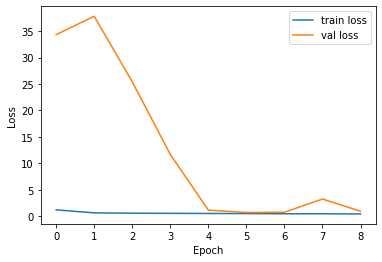

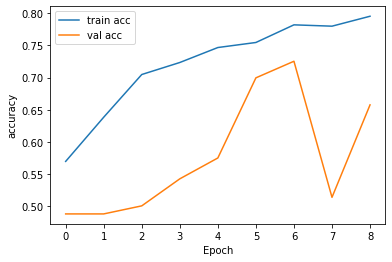

In [38]:
# plot hasil ke grafik
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label='train loss')
ax.plot(history.history['val_loss'],label='val loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.legend()

fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label='train acc')
ax.plot(history.history['val_accuracy'],label='val acc')
ax.set_xlabel('Epoch')
ax.set_ylabel('accuracy')

plt.legend()

In [41]:
val_accuracy = np.mean(history.history['accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 72.17%


## MODEL IMPROVEMENT

Pada bagian ini, akan melakukan improvisasi model sebelumnya agar lebih baik. pada model improvement dilakukan variasi kernel size tiap layer, penambahan padding, penambahan dropout layers yang bervariasi, serta penambahan layers pada bagian flatten

In [45]:
#konvolusi 1
model_imp= Sequential()
model_imp.add(Conv2D(filters=16, kernel_size=2, activation= 'relu', input_shape= input))
model_imp.add(MaxPooling2D(pool_size=4, strides=4))

#konvolusi 2
model_imp.add(Conv2D(filters=32, kernel_size=2, activation= 'relu', padding='valid' ,input_shape= input))
model_imp.add(MaxPooling2D(pool_size=3, strides=3))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))

#konvolusi 3
model_imp.add(Conv2D(filters=64, kernel_size=2, activation= 'relu' , padding='same',input_shape= input))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))

#konvolusi 4
model_imp.add(Conv2D(filters=128, kernel_size=2, activation= 'relu' , padding='same',input_shape= input))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))

# flatten
model_imp.add(Flatten())
model_imp.add(Dense(units=256, activation= 'relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.2))
model_imp.add(Dense(units=128, activation= 'relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.3))


model_imp.add(Dense(units=1, activation= 'sigmoid'))

In [46]:
model_imp.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
epochs= 10
history= model_imp.fit(training_dataset, batch_size= BATCH, epochs= epochs,
                         validation_data= val_dataset, callbacks= callbacks, verbose=1)

Epoch 1/10
136/136 [==============================] - 135s 987ms/step - loss: 0.6994 - accuracy: 0.5093 - val_loss: 0.6897 - val_accuracy: 0.5934
Epoch 2/10
136/136 [==============================] - 132s 966ms/step - loss: 0.6611 - accuracy: 0.6033 - val_loss: 0.6227 - val_accuracy: 0.6982
Epoch 3/10
136/136 [==============================] - 131s 961ms/step - loss: 0.5830 - accuracy: 0.7076 - val_loss: 0.5468 - val_accuracy: 0.7365
Epoch 4/10
136/136 [==============================] - 131s 964ms/step - loss: 0.5729 - accuracy: 0.7177 - val_loss: 0.5594 - val_accuracy: 0.7181
Epoch 5/10
136/136 [==============================] - 131s 965ms/step - loss: 0.5631 - accuracy: 0.7242 - val_loss: 0.5419 - val_accuracy: 0.7476
Epoch 6/10
136/136 [==============================] - 131s 961ms/step - loss: 0.5421 - accuracy: 0.7374 - val_loss: 0.5489 - val_accuracy: 0.7247
Epoch 7/10
136/136 [==============================] - 130s 956ms/step - loss: 0.5440 - accuracy: 0.7399 - val_loss: 0.4995 -

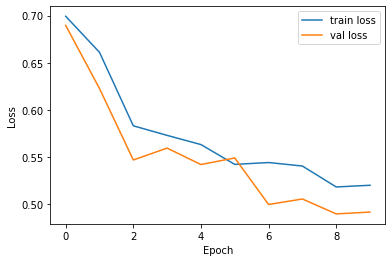

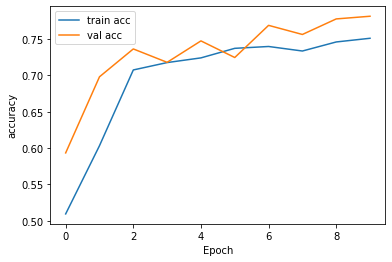

In [47]:
# plot hasil ke grafik
fig2, ax2 = plt.subplots()
ax2.plot(history.history['loss'],label='train loss')
ax2.plot(history.history['val_loss'],label='val loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.legend()

fig2, ax2 = plt.subplots()
ax2.plot(history.history['accuracy'],label='train acc')
ax2.plot(history.history['val_accuracy'],label='val acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')

plt.legend()

In [48]:
val_accuracy_imp = np.mean(history.history['accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy_imp*100))


val_accuracy: 69.70%


**PEMBAHASAN MODEL**

Model yang dibangun pada notebook ini ada 2 yaaitu model awal (model) serta model yg telah diimprove (model_imp). Model awal yang dihasilkan memiliki akurasi yang cukup rendah dan pada grafiknya kita dapat lihat bahwa hasil train_loss dibawah val_loss yang mengindikasikan underfit. Kemudian kita dapat lihat train_loss yang datar yang artinya ada indikaasi gradien problem disana daan perlu ditindaklanjuti dengan improvemnet. Maka itu didapatkan model_imp yang merupakan peningkatan dari model awal. Pada model_imp ini memiliki rerata akurasi yang ternyata belum baik yaitu 66.6% namun kita akan gunakan model ini karena hasil grafik menunjukkan hasil yang lebih baik daripada sebelumnya. Kita dapat melihat nilai loss dari train maupun data validasi mengalami penurunan seperti yang kita harapkan. Kemudian kedua garis ini tidak berbeda jauh atau berhimpitan yang menandakan bahwa antaara data train dan validasi ini menghasilkan nilai yang mendekati padaa suatu titik data. Maka dari itu model ini dapat digunakan untuk memprediksi anime vs cartoon namun perlu ditingkatkan lagi akurasi pemodelannya.

### MAKE PIPELINE AND TRAIN MODEL


In [49]:
# split data ulang untuk kerpeluan membuat pipeline

# traindata_pipe, valdata_pipe = train_test_split(
#     tf.io.gfile.glob(main_path +'*\*\*'),
#     test_size=0.2, random_state=5)

In [50]:
data_pipe= main_path
data_dir = pathlib.Path(data_pipe)

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# membuat fungsi untuk augmentasi data
def aug_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [52]:
# split data train dan validasi
t_pipe = tf.keras.preprocessing.image_dataset_from_directory(data_pipe, validation_split=0.2,subset="training",seed=24,image_size= (img_height, img_width),batch_size=BATCH)
v_pipe = tf.keras.preprocessing.image_dataset_from_directory(data_pipe, validation_split=0.2,subset="validation",seed=24,image_size= (img_height, img_width),batch_size=BATCH)

Found 8892 files belonging to 2 classes.
Using 7114 files for training.
Found 8892 files belonging to 2 classes.
Using 1778 files for validation.


In [53]:
# rescaling data agar berada pada rentang 0-1
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = t_pipe.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [54]:
t_pipe = t_pipe.cache().prefetch(buffer_size=AUTOTUNE)
t_pipe = t_pipe.map(aug_pipeline, num_parallel_calls=AUTOTUNE)

v_pipe = v_pipe.cache().prefetch(buffer_size=AUTOTUNE)
v_pipe = v_pipe.map(aug_pipeline, num_parallel_calls=AUTOTUNE)

In [140]:
#model_imp.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
history_pipe= model_imp.fit(t_pipe,validation_data=v_pipe,epochs=10)

Epoch 1/10
223/223 [==============================] - 173s 767ms/step - loss: 1.2336 - accuracy: 0.5933 - val_loss: 0.6492 - val_accuracy: 0.6907
Epoch 2/10
223/223 [==============================] - 171s 754ms/step - loss: 0.6198 - accuracy: 0.6825 - val_loss: 0.5962 - val_accuracy: 0.7300
Epoch 3/10
223/223 [==============================] - 149s 667ms/step - loss: 0.5821 - accuracy: 0.7173 - val_loss: 0.5879 - val_accuracy: 0.7385
Epoch 4/10
223/223 [==============================] - 157s 693ms/step - loss: 0.5510 - accuracy: 0.7414 - val_loss: 0.5691 - val_accuracy: 0.7497
Epoch 5/10
223/223 [==============================] - 161s 720ms/step - loss: 0.5449 - accuracy: 0.7380 - val_loss: 0.5786 - val_accuracy: 0.7469
Epoch 6/10
223/223 [==============================] - 148s 660ms/step - loss: 0.5359 - accuracy: 0.7498 - val_loss: 0.5587 - val_accuracy: 0.7655
Epoch 7/10
223/223 [==============================] - 138s 617ms/step - loss: 0.5216 - accuracy: 0.7631 - val_loss: 0.5327 -

## MODEL EVALUATE

In [55]:
y_pred = model_imp.predict(test_dataset)
y_pred = (y_pred > 0.5)
y_pred

34/34 [==============================] - 9s 244ms/step


array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [56]:
# membuat confusion matrix
cm = confusion_matrix(test_dataset.classes, y_pred)
cm

array([[361, 191],
       [ 74, 458]], dtype=int64)

<AxesSubplot:>

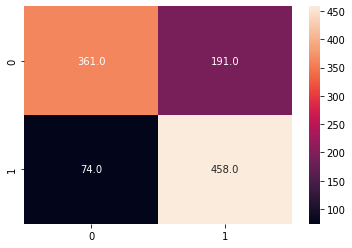

In [57]:
sns.heatmap(cm, annot=True,fmt=".1f")

In [58]:
print(classification_report(test_dataset.classes, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       552
           1       0.71      0.86      0.78       532

    accuracy                           0.76      1084
   macro avg       0.77      0.76      0.75      1084
weighted avg       0.77      0.76      0.75      1084



### Pembaahasan model evaluate

Hasil dari improvisasi model kemudian akan dievaluasi berdasarkan confusion matrix (cm) dan juga classification report (cr). Berdasarkan cm, kiota dapat lihat bahwa ada beberapa data yang salah terprediksi. untuk data yg terprediksi 1 namun aslinya 0 atau FP ada 191 data sedangkan untuk daata yg terprediksi 0 namun aslinya 1 atau FN ada 74 data.

Kemudian dari hasil cr, kita dapat melihat bahwa aaccuracy yang dihasilkan model ini adalah 76% dimana nilai ini terbilang cukup namun belum begitu baik karena masih dibawah 90%. precision untuk target 0 sebesar 83%, yang artinya 83% data pada target tersebut terprediksi benar dari jumlah data antara TP dan FP. untuk recall pada target 0 yang dihasilkan adalah 65% yang artinya jumlah TP ada 65% dari jumlah data TP dan FN. 

Jadi, berdasarkan metriks evaluasi diatas, kitaa dapat mengetahui bahwa model ini perlu improvisasi tingkat lanjut agar menjadi lebih baik dalam memprediksi

## DATA INFERENCE TEST

In [59]:
inf =  os.listdir('inf_data_m2')
inf_path = ('inf_data_m2')
data_inf = glob.glob(inf_path + '\\*.jpg')
data_inf



['inf_data_m2\\11112549_664592917001876_4887932860457846547_n-e1428922632735-256x256.jpg',
 'inf_data_m2\\a6c33c24d9261b04543e7babaac6406a.jpg',
 'inf_data_m2\\unnamed.jpg',
 'inf_data_m2\\_1652261301_c2ced39c.jpg']

In [120]:
pathinf = ('inf_data_m2\\*')
data_dir_inf = pathlib.Path(inf_path)

In [61]:
# membuat dataframe pada inference data

def create_inf_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image))

  return pd.DataFrame(data, columns= ['images'])

inf_df= create_inf_dataframe(data_inf)
inf_df= inf_df.sample(frac=1, random_state=1).reset_index(drop=True)
inf_df

,images
0,inf_data_m2\_1652261301_c2ced39c.jpg
1,inf_data_m2\unnamed.jpg
2,inf_data_m2\11112549_664592917001876_488793286...
3,inf_data_m2\a6c33c24d9261b04543e7babaac6406a.jpg


In [63]:
img.shape

(256, 256, 3)

In [118]:
anime_path

'Training Data\\Anime'

In [122]:
inf_path

'inf_data_m2'

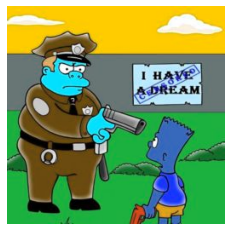

1/1 [==============================] - 0s 42ms/step
[[0.8096086]]
Cartoon


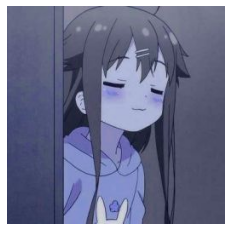

1/1 [==============================] - 0s 52ms/step
[[0.4684184]]
Anime


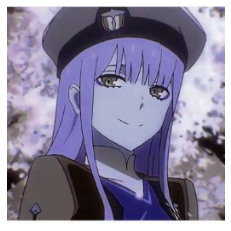

1/1 [==============================] - 0s 38ms/step
[[0.4567309]]
Anime


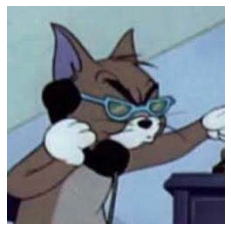

1/1 [==============================] - 0s 67ms/step
[[0.28952295]]
Anime


In [152]:
for a in data_inf:
    img = cv2.imread(a)
    rr= cv2.resize(img,(250,250))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    x = image.img_to_array(rr)
    x = np.expand_dims(x, axis=0) 
    images = np.vstack([x])
    classes = model_imp.predict(images) 
    print(classes) 
    if classes[0][0] > 0.5:
       print('Cartoon')
    else:
       print('Anime')

## KESIMPUILAN

Data gambar yg digunakan adalah gambar anime dan juga kartun. size data cukup bervariasi namun ada banyak data yang memiliki ukuran yang sama pada sumbu horizintalnya serta ukuran gambar terdistibusi secara normal. dataa antara 2 kategori ini pun cukup balance.
Berdasarkan hasil pemodelan awal dan improvisasi model, model_imp dipilih dan diras lebih baik dari model awal berdasarkan grafik hasil. grafik teresbut menunjukkan model_imp terlihat tidak memiliki perbedaan yang cukup jauh antara train dan val loss walaupun secara rerata akurasi model awal lebih tinggi namun ada kecendrungan underfit pada model awal.

Berdasarkan hasil metriks evaluasi dengan model_imp, akurasi yang dihasilkan adalah 76%. untuk recall yang dihasilkan adalah 86% dan precision 71%. Model ini dirasa belum cukup baik karena ada kemungkinan yang cukup besar salah memprediksi. perlu ditingkatkan pemodelan dari segi layer, optimizer, dropout, dll sehingga dapat meningkatkan akurasi model